In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
from linares_plot import *
import os
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
import scipy
from scikits.bootstrap import ci 
from scipy.stats import norm
import matplotlib.mlab as mlab


c_r1= '#e66101' #'#fdb863' # '#998ec3' #'#d8b365' #, '#8da0cb'
c_r3= '#5e3c99' #'#b2abd2' #'#f1a340' #'#5ab4ac' #'#fc8d62'
c_d0='grey'
c_d3 = '#91cf60'



#data_psychophysics_corrected
data = pd.read_csv('C:\\Users\\David\\Dropbox\\IDIBAPS\\my code\\Project 1 (master thesis)\\idibaps_psychophysics')
df=data.loc[(data['type']==1) | (data['type']==2)]

2403


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Outliers in 1 = 2, limit=3.79cm
Outliers in 2 = 4, limit=2.92cm
Outliers in 3 = 5, limit=3.18cm
Outliers in 4 = 1, limit=2.81cm
Outliers in 5 = 9, limit=2.41cm
Outliers in 6 = 6, limit=5.03cm
Outliers in 7 = 6, limit=3.33cm
Outliers in 8 = 7, limit=2.93cm
Outliers in 9 = 7, limit=3.96cm
Outliers in 10 = 4, limit=4.12cm
Outliers in 11 = 6, limit=4.49cm
Outliers in 12 = 4, limit=3.21cm
Outliers in 13 = 7, limit=3.33cm
Outliers in 14 = 5, limit=3.59cm
Outliers in 15 = 4, limit=3.5cm
Outliers in 16 = 4, limit=4.16cm
Outliers in 17 = 8, limit=3.32cm
Outliers in 18 = 7, limit=4.54cm
2307


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


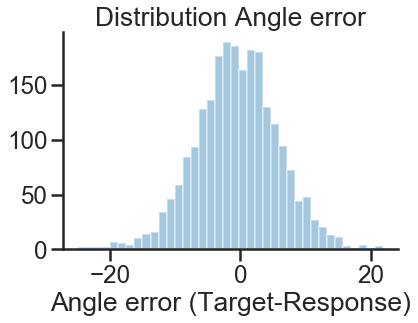

NormaltestResult(statistic=18.13955562885638, pvalue=0.0001150921076113315)

In [3]:
print(len(df))

def mod(target,report,radius_t, radius_r):
    #units given in degrees and cm
    y_t=np.array(radius_t*np.sin(np.radians(target)),dtype=np.float)
    x_t=np.array(radius_t*np.cos(np.radians(target)),dtype=np.float)
    y_r=np.array(radius_r*np.sin(np.radians(report)),dtype=np.float)
    x_r=np.array(radius_r*np.cos(np.radians(report)),dtype=np.float)
    m = np.sqrt((x_t - x_r)**2 + (y_t - y_r)**2)
    return m


modules = [round(mod(df.loc[i,'A_T'], df.loc[i,'A_R'], df.loc[i,'r_T'], df.loc[i,'r_R']),3) for i in df.index]
df['modules']=modules


from pandas import concat
frames=[]
for group_label in df.subject.unique():
    sub_group=df.groupby('subject').get_group(group_label)
    #CI
    #interval = sub_group.quantile([0.025, 0.975]).unstack(level=1)['A_err']
    #removed_out = sub_group.loc[(sub_group['A_err']>interval.iloc[0]) & (sub_group['A_err']<interval.iloc[1])] 
    #
    #Quartiles
    limit=sub_group['modules'].mean() + 2*sub_group['modules'].std()
    #print(round(limit,2))
    removed_out =sub_group.loc[sub_group['modules']<limit  ]
    
    
    frames.append(removed_out)
    
    #Print the result
    before_outliers=len(sub_group)
    after_outliers=len(removed_out)
    print( 'Outliers in ' + str(group_label) + ' = ' +str(before_outliers-after_outliers) + ', limit=' +str(round(limit,2))  + 'cm')
    


df = concat(frames)
print(len(df))

### Distribution A_Err in cw-ccw
sns.distplot(df['A_err'], kde=False)
plt.title('Distribution Angle error')
plt.legend(frameon=False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.xlabel('Angle error (Target-Response)')
plt.show()

scipy.stats.normaltest(df['A_err'])

In [4]:
## Functions to use

def circ_dist(a1,a2):
    ## Returns the minimal distance in angles between to angles 
    op1=abs(a2-a1)
    angs=[a1,a2]
    op2=min(angs)+(360-max(angs))
    options=[op1,op2]
    return min(options)



def get_quadrant(angle): 
    #angle in degrees, return the quadrant which it belongs to
    if angle>=0 and angle<=90:
        Q=1
    elif angle>90 and angle<=180:
        Q=2
    elif angle>180 and angle<=270:
        Q=3
    elif angle>270 and angle<=360:
        Q=4
    
    return Q


def cw_ccw_detector(target, NT):
    #print [target, NT,get_quadrant(target),get_quadrant(NT) ]
    #it returns the relative position of the target respect the NT
    if abs(target-NT)<180:
        if target<NT: 
            o='cw'
        else: 
            o='ccw'
    else:
        if target<NT: 
            o='ccw'
        else: 
            o='cw'
    #Ecceptions
    if [get_quadrant(target),get_quadrant(NT) ] == [1,4] : o= 'ccw'
    if [get_quadrant(target),get_quadrant(NT) ] == [4,1] : o= 'cw'
    
    return o



In [5]:
#Add necessary column
orients=[]
for i in range(0, len(df)):
    orients.append(cw_ccw_detector(df['A_T'].iloc[i], df['A_NT'].iloc[i]))

    
df['cw_ccw']=orients
df['dist_T_NT']=abs(df['A_T']-df['A_NT'])

In [6]:
##### DISTANCE TO MEAN OF CW AND CCW as a measure
means_cw={}

for Subj in df.subject.unique():
    d_subj = df.groupby('subject').get_group(Subj)
    for ori in ['cw', 'ccw']:
        for distance in df.dist_T_NT.unique():
            for radius in df.r_T.unique():
                for delay in df.delay.unique():
                    mean_cw = round(d_subj.loc[ (d_subj['cw_ccw']==ori)  & (d_subj['r_T']==radius)
                                               & (d_subj['dist_T_NT']==distance) & (d_subj['delay']==delay) ,'A_err'].mean(), 3)
                    
                    means_cw[str(Subj)  + '_' + str(radius) + '_' +str(distance) +'_'+ str(delay) + '_' +ori] = mean_cw
                

        
cw_ccw_distance=[]

for i in df.index:
    or_ = df.loc[i, 'cw_ccw']
    if or_ == 'cw':
        or_cont = 'ccw'
    elif or_ =='ccw':
        or_cont = 'cw' 
    else:
        print('Error')
    idx =  str(df.loc[i, 'subject'])+ '_' + str(df.loc[i, 'r_T']) + '_' +str(df.loc[i, 'dist_T_NT']) +'_' +str(df.loc[i, 'delay']) +'_'  + or_cont
    #
    if or_ == 'ccw':
        cw_ccw_distance.append(df.loc[i, 'A_err'] - means_cw[idx] )  
    elif or_ =='cw':
        cw_ccw_distance.append( means_cw[idx] - df.loc[i, 'A_err'])  
    else:
        print('Error')
    


df['distance_A_err'] = np.array(cw_ccw_distance)/2
print(len(df))

#Remove null
df=df[~df['distance_A_err'].isnull()]
print(len(df))

2307
2291


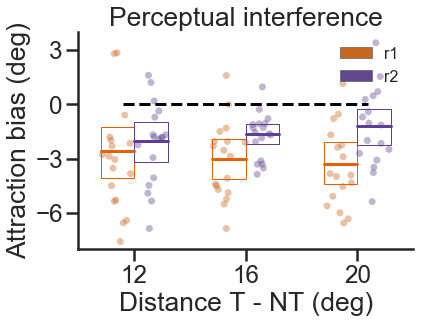

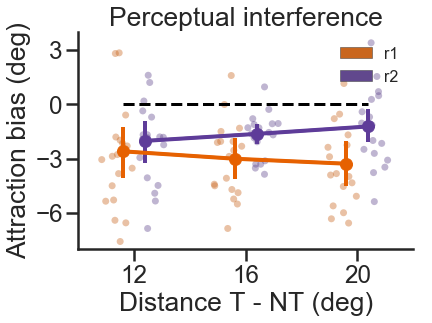

[0.09205386517755408, 5.016737100011929e-06, 1.866101968696445e-11]
           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_A_err
No. Observations: 1169    Method:             REML          
No. Groups:       18      Scale:              6.7009        
Min. group size:  16      Likelihood:         -2806.6805    
Max. group size:  98      Converged:          Yes           
Mean group size:  64.9                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.388    1.452  0.267 0.789 -2.457  3.233
r_T               -0.275    0.127 -2.161 0.031 -0.524 -0.026
dist_T_NT         -0.329    0.086 -3.820 0.000 -0.497 -0.160
r_T:dist_T_NT      0.031    0.008  3.991 0.000  0.016  0.046
Group Var          2.519    0.349                           



In [18]:
plt.figure()
linares_plot(x='dist_T_NT', y='distance_A_err', hue='r_T', order=[12,16,20], hue_order=[7.72,13.68],
             alpha=0.4, palette=[c_r1, c_r3], df=df.loc[df['delay']==0], point_size=7,  by_subj=True, subj_col='subject')
plt.plot([-0.1,2.1], [0,0], 'k--');
plt.ylim(-8,4);
plt.title('Perceptual interference')
plt.xlabel('Distance T - NT (deg)');
plt.ylabel('Attraction bias (deg)');
plt.yticks([-6,-3, 0, 3]);
l = plt.legend(loc=1, frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('r1')
l.get_texts()[1].set_text('r2')
plt.show()


plt.figure()
linares_plot(x='dist_T_NT', y='distance_A_err', hue='r_T', order=[12,16,20], hue_order=[7.72,13.68],
             alpha=0.4, palette=[c_r1, c_r3], df=df.loc[df['delay']==0], point_size=7,  by_subj=True, subj_col='subject',
            plot_box='line')
plt.plot([-0.1,2.1], [0,0], 'k--');
plt.ylim(-8,4);
plt.title('Perceptual interference')
plt.xlabel('Distance T - NT (deg)');
plt.ylabel('Attraction bias (deg)');
plt.yticks([-6,-3, 0, 3]);
l = plt.legend(loc=1, frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('r1')
l.get_texts()[1].set_text('r2')
plt.show()



### TTESTS

df_d0 = df.loc[df['delay']==0]

p_values=[]

for dist in [12, 16, 20]:
    a= df_d0[(df_d0['r_T'] == 7.72 ) & (df_d0['dist_T_NT'] == dist) ]['distance_A_err']
    b= df_d0[(df_d0['r_T'] == 13.68 ) & (df_d0['dist_T_NT'] == dist) ]['distance_A_err']
    p_values.append(ttest_ind(a,b)[1])

print(p_values)

#### MODEL
res_m = smf.mixedlm(formula='distance_A_err ~ r_T * dist_T_NT', data=df_d0, groups=df_d0['subject']).fit()
print(res_m.summary())


In [13]:
## Mixed model (subject as random intercept)
res_m = smf.mixedlm(formula='distance_A_err ~ r_T * dist_T_NT*delay', data=df, groups=df['subject']).fit()
print(res_m.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: distance_A_err
No. Observations:   2291    Method:             REML          
No. Groups:         18      Scale:              9.6171        
Min. group size:    31      Likelihood:         -5893.2175    
Max. group size:    191     Converged:          Yes           
Mean group size:    127.3                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.413    1.716  0.241 0.810 -2.950  3.777
r_T                 -0.276    0.152 -1.814 0.070 -0.575  0.022
dist_T_NT           -0.331    0.103 -3.210 0.001 -0.533 -0.129
r_T:dist_T_NT        0.031    0.009  3.344 0.001  0.013  0.050
delay               -2.572    0.796 -3.231 0.001 -4.133 -1.012
r_T:delay            0.243    0.072  3.349 0.001  0.101  0.385
dist_

In [7]:
#Measure d3-d0

d0={}

for Subj in df.subject.unique():
    d_subj = df.groupby('subject').get_group(Subj)
    for ori in ['cw', 'ccw']:
        for distance in df.dist_T_NT.unique():
            for radius in df.r_T.unique():
                mean_d0 = round(d_subj.loc[ (d_subj['cw_ccw']==ori)  & (d_subj['r_T']==radius)
                                           & (d_subj['dist_T_NT']==distance) & (d_subj['delay']==0) ,'distance_A_err'].mean(), 3)

                d0[str(Subj)  + '_' + str(radius) + '_' +str(distance) + '_' +ori] = mean_d0



dist_A_err_d3_d0=[]

for i in df.index:
    idx =  str(df.loc[i, 'subject'])+ '_' + str(df.loc[i, 'r_T']) + '_' +str(df.loc[i, 'dist_T_NT']) +'_'  + df.loc[i, 'cw_ccw']
    #
    dist_A_err_d3_d0.append(df.loc[i, 'distance_A_err'] - d0[idx] )

    


df['dist_A_err_d3_d0'] = dist_A_err_d3_d0

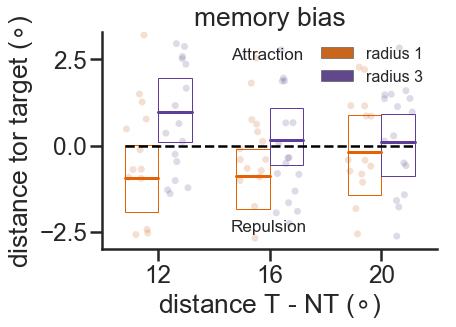

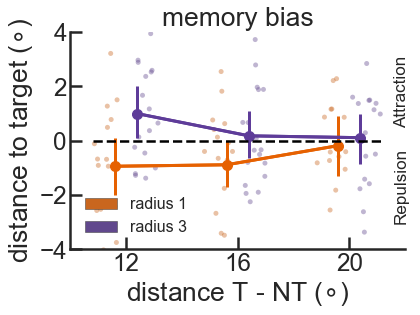

[6.968761461100693e-06, 0.012289307381032517, 0.4968561314413179]
            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dist_A_err_d3_d0
No. Observations: 1122    Method:             REML            
No. Groups:       18      Scale:              11.5932         
Min. group size:  15      Likelihood:         -2987.4482      
Max. group size:  93      Converged:          Yes             
Mean group size:  62.3                                        
---------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept      -7.839     1.874  -4.182  0.000  -11.512  -4.165
r_T             0.739     0.170   4.346  0.000    0.406   1.073
dist_T_NT       0.361     0.114   3.153  0.002    0.136   0.585
r_T:dist_T_NT  -0.035     0.010  -3.342  0.001   -0.055  -0.014
Group Var       0.679     0.092                           

In [16]:

linares_plot(x='dist_T_NT', y='dist_A_err_d3_d0', hue='r_T', order=[12,16,20], hue_order=[7.72,13.68], 
             alpha=0.2, palette=[c_r1, c_r3], df=df.loc[df['delay']==3], point_size=7,  by_subj=True, subj_col='subject',
              plot_box=True)

plt.plot([-0.3, 2.3], [0,0], 'k--', linewidth=2.5);
plt.title('memory bias')
plt.xlabel(r'distance T - NT ($\circ$)');
plt.ylabel(r'distance tor target ($\circ$)');
plt.yticks([ -5, -2.5,  0, 2.5, 5]);
plt.ylim(-3,3.3);

l = plt.legend(loc='best', frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('radius 1')
l.get_texts()[1].set_text('radius 3')


plt.text(0.65, 2.5, 'Attraction', fontsize=17);
plt.text(0.65, -2.5, 'Repulsion', fontsize=17);

plt.show()


linares_plot(x='dist_T_NT', y='dist_A_err_d3_d0', hue='r_T', order=[12,16,20], hue_order=[7.72,13.68], 
             alpha=0.4, palette=[c_r1, c_r3], df=df.loc[df['delay']==3], point_size=5,  
             by_subj=True, subj_col='subject',
              plot_box='line', LW=3, MS=10)

plt.plot([-0.3, 2.3], [0,0], 'k--', linewidth=2.5);
plt.title('memory bias')
plt.xlabel(r'distance T - NT ($\circ$)');
plt.ylabel(r'distance to target ($\circ$)');
plt.yticks([ -4, -2,  0, 2, 4]);
plt.ylim(-4,4);
plt.tick_params(direction='in')

l = plt.legend(loc=3, frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('radius 1')
l.get_texts()[1].set_text('radius 3')


plt.text(2.4, 2.7, 'Attraction', fontsize=17, rotation='vertical');
plt.text(2.4, -0.7, 'Repulsion', fontsize=17, rotation='vertical');
plt.show()


## pvalues
p_values=[]
for dist in [12, 16, 20]:
    a= df[(df['r_T'] == 7.72 ) & (df['dist_T_NT'] == dist) ]['dist_A_err_d3_d0']
    b= df[(df['r_T'] == 13.68 ) & (df['dist_T_NT'] == dist) ]['dist_A_err_d3_d0']
    p_values.append(ttest_ind(a,b)[1])

print(p_values)


#### MODEL
res_m = smf.mixedlm(formula='dist_A_err_d3_d0 ~ r_T * dist_T_NT', data=df.loc[df['delay']==3], groups=df.loc[df['delay']==3, 'subject']).fit()
print(res_m.summary())

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mean

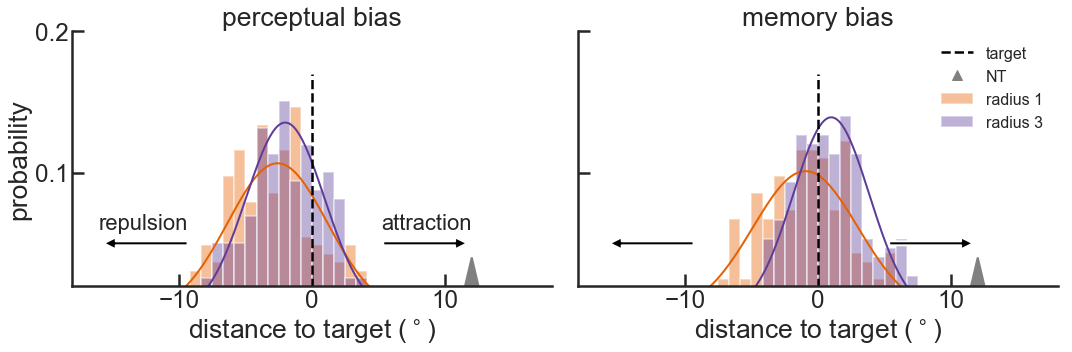

In [8]:
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)



plt.subplot(121)
sns.distplot(df.loc[(df['delay']==0) & (df['dist_T_NT']==12) & (df['r_T']==7.72), 'distance_A_err'] , bins=np.linspace(-10,10,25), 
              fit=norm, kde=False, fit_kws={"color":c_r1, 'linewidth':2}, label='radius 1', color=c_r1, ax=ax)
sns.distplot(df.loc[(df['delay']==0) & (df['dist_T_NT']==12) & (df['r_T']==13.68), 'distance_A_err'] , bins=np.linspace(-10,10,25),
             fit=norm, kde=False, fit_kws={"color":c_r3, 'linewidth':2}, label='radius 3',  color=c_r3,ax=ax)
plt.plot([0, 0], [0,0.17], 'k--', linewidth=2.5, label='target');
plt.xlim(-18,18)
plt.ylim(0.02)
plt.yticks([0.1,0.2])
#plt.plot([12, 12], [0,0.17], color='grey', linestyle='-', linewidth=2.5, label='NT');
plt.plot((12,10), "^", color='grey', markersize=10, label='NT');

#l = plt.legend(loc='best', frameon=False, prop={'size': 16})
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xlabel(r'distance to target ($^\circ$)')
plt.ylabel('probability')
plt.text(5.2, 0.06, 'attraction', fontsize=22);
plt.text(-16, 0.06, 'repulsion', fontsize=22);
#plt.title(r'12$\circ$: Delay0')
plt.title('perceptual bias')
plt.annotate('', xy=(-16, 0.05),  xytext=(-9, 0.05),  arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom');

plt.annotate('', xy=(12, 0.05), xytext=(5, 0.05), arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom');


pts = [(11, 0), (12, 0.04), (13, 0)]
triangle = plt.Polygon(pts, color='grey', fill=True, edgecolor='grey')
ax.add_patch(triangle)


plt.subplot(122)
sns.distplot(df.loc[(df['delay']==3) & (df['dist_T_NT']==12) & (df['r_T']==7.72), 'dist_A_err_d3_d0'] , bins=np.linspace(-10,10,25),
              fit=norm, kde=False, fit_kws={"color":c_r1, 'linewidth':2}, label='radius 1', color=c_r1, ax=ax2)
sns.distplot(df.loc[(df['delay']==3) & (df['dist_T_NT']==12) & (df['r_T']==13.68), 'dist_A_err_d3_d0'] , bins=np.linspace(-10,10,25),
             fit=norm, kde=False, fit_kws={"color":c_r3, 'linewidth':2}, label='radius 3',  color=c_r3, ax=ax2)
plt.plot([0, 0], [0,0.17], 'k--', linewidth=2.5, label='target');
plt.xlim(-18,18)
plt.ylim(0.02)
plt.yticks([0.1,0.2])

##triangulo locura
plt.plot((12,10), "^", color='grey', markersize=10, label='NT');



l = plt.legend(loc='best', frameon=False, prop={'size': 16})
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xlabel(r'distance to target ($^\circ$)')
plt.ylabel('')
#plt.text(5.2, 0.06, 'attraction', fontsize=22);
#plt.text(-16, 0.06, 'repulsion', fontsize=22);
#plt.title(r'12$\circ$: Delay3 - Delay0')
plt.yticks([0.1,0.2], ['', ''])

plt.title('memory bias')
plt.annotate('', xy=(-16, 0.05),  xytext=(-9, 0.05),  arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom');

plt.annotate('', xy=(12, 0.05), xytext=(5, 0.05), arrowprops=dict(facecolor='black', shrink=0.05),
           horizontalalignment='left', verticalalignment='bottom');




pts = [(11, 0), (12, 0.04), (13, 0)]
triangle = plt.Polygon(pts, color='grey', fill=True, edgecolor='grey')
ax2.add_patch(triangle)


plt.tight_layout()

In [9]:
df_cont=data.loc[data['type']==0]

3396


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Outliers in 1 = 2, limit=2.81
Outliers in 2 = 8, limit=2.66
Outliers in 3 = 2, limit=4.03
Outliers in 4 = 1, limit=2.67
Outliers in 5 = 6, limit=2.33
Outliers in 6 = 5, limit=4.51
Outliers in 7 = 7, limit=2.53
Outliers in 8 = 10, limit=2.48
Outliers in 9 = 7, limit=3.48
Outliers in 10 = 10, limit=3.76
Outliers in 11 = 6, limit=4.06
Outliers in 12 = 2, limit=3.48
Outliers in 13 = 9, limit=2.41
Outliers in 14 = 9, limit=3.31
Outliers in 15 = 9, limit=2.46
Outliers in 16 = 11, limit=2.49
Outliers in 17 = 10, limit=2.79
Outliers in 18 = 7, limit=3.79
3275


No handles with labels found to put in legend.


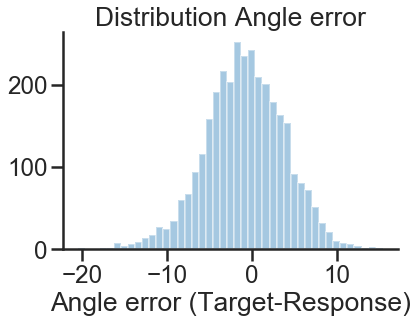

In [10]:
print(len(df_cont))

def mod(target,report,radius_t, radius_r):
    #units given in degrees and cm
    y_t=np.array(radius_t*np.sin(np.radians(target)),dtype=np.float)
    x_t=np.array(radius_t*np.cos(np.radians(target)),dtype=np.float)
    y_r=np.array(radius_r*np.sin(np.radians(report)),dtype=np.float)
    x_r=np.array(radius_r*np.cos(np.radians(report)),dtype=np.float)
    m = np.sqrt((x_t - x_r)**2 + (y_t - y_r)**2)
    return m


modules = [round(mod(df_cont.loc[i,'A_T'], df_cont.loc[i,'A_R'], df_cont.loc[i,'r_T'], df_cont.loc[i,'r_R']),3) for i in df_cont.index]
df_cont['modules']=modules


from pandas import concat
frames=[]
for group_label in df_cont.subject.unique():
    sub_group=df_cont.groupby('subject').get_group(group_label)
    #CI
    #interval = sub_group.quantile([0.025, 0.975]).unstack(level=1)['A_err']
    #removed_out = sub_group.loc[(sub_group['A_err']>interval.iloc[0]) & (sub_group['A_err']<interval.iloc[1])] 
    #
    #Quartiles
    limit=sub_group['modules'].mean() + 2*sub_group['modules'].std()
    #print(round(limit,2))
    removed_out =sub_group.loc[sub_group['modules']<limit  ]
    
    
    frames.append(removed_out)
    
    #Print the result
    before_outliers=len(sub_group)
    after_outliers=len(removed_out)
    print( 'Outliers in ' + str(group_label) + ' = ' +str(before_outliers-after_outliers) + ', limit=' +str(round(limit,2)) )
    


df_cont = concat(frames)
print(len(df_cont))



### Distribution A_Err in cw-ccw
sns.distplot(df_cont['A_err'], kde=False)
plt.title('Distribution Angle error')
plt.legend(frameon=False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.xlabel('Angle error (Target-Response)')
plt.show()

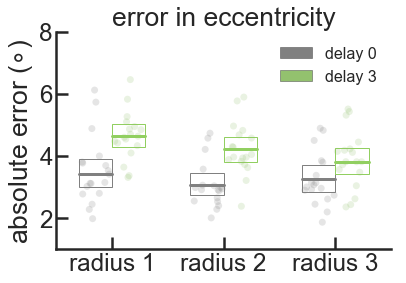

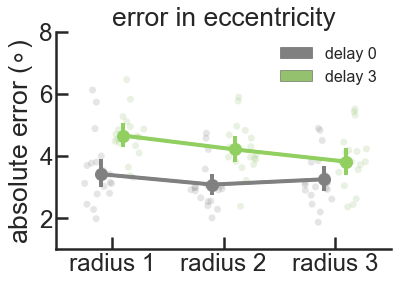

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: abs_err   
No. Observations: 3275    Method:             REML      
No. Groups:       18      Scale:              7.7495    
Min. group size:  70      Likelihood:         -8030.0091
Max. group size:  230     Converged:          Yes       
Mean group size:  181.9                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      3.577    0.348 10.283 0.000  2.895  4.258
r_T           -0.028    0.028 -0.998 0.318 -0.083  0.027
delay          0.730    0.146  4.995 0.000  0.443  1.016
r_T:delay     -0.038    0.013 -2.825 0.005 -0.064 -0.012
Group Var      0.484    0.065                           



In [27]:
df_cont['abs_err']=abs(df_cont['A_err'].copy())

linares_plot(x='r_T', y='abs_err', hue='delay', hue_order=[0,3], order=[7.72,10.7,13.68], df=df_cont,palette=[c_d0, c_d3], 
            alpha=0.2, point_size=7,  by_subj=True, subj_col='subject')
plt.legend(frameon=False)
plt.title('error in eccentricity')
plt.xlabel('')
plt.xticks([0,1,2], ['radius 1', 'radius 2', 'radius 3'])
plt.ylabel(r'absolute error ($\circ$)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.ylim(1, 8)
l = plt.legend(loc='best', frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('delay 0')
l.get_texts()[1].set_text('delay 3')
plt.show()


linares_plot(x='r_T', y='abs_err', hue='delay', hue_order=[0,3], order=[7.72,10.7,13.68], df=df_cont,palette=[c_d0, c_d3], 
            alpha=0.2, point_size=7,  by_subj=True, subj_col='subject', plot_box='line')
plt.legend(frameon=False)
plt.title('error in eccentricity')
plt.xlabel('')
plt.xticks([0,1,2], ['radius 1', 'radius 2', 'radius 3'])
plt.ylabel(r'absolute error ($\circ$)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.ylim(1, 8)
l = plt.legend(loc='best', frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('delay 0')
l.get_texts()[1].set_text('delay 3')
plt.show()


### Model
res_m = smf.mixedlm(formula='abs_err ~ r_T*delay ', data=df_cont, groups=df_cont['subject']).fit()
print(res_m.summary())
             
             

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
C:\Users\David\Anaconda3\envs\python3\lib\site-package

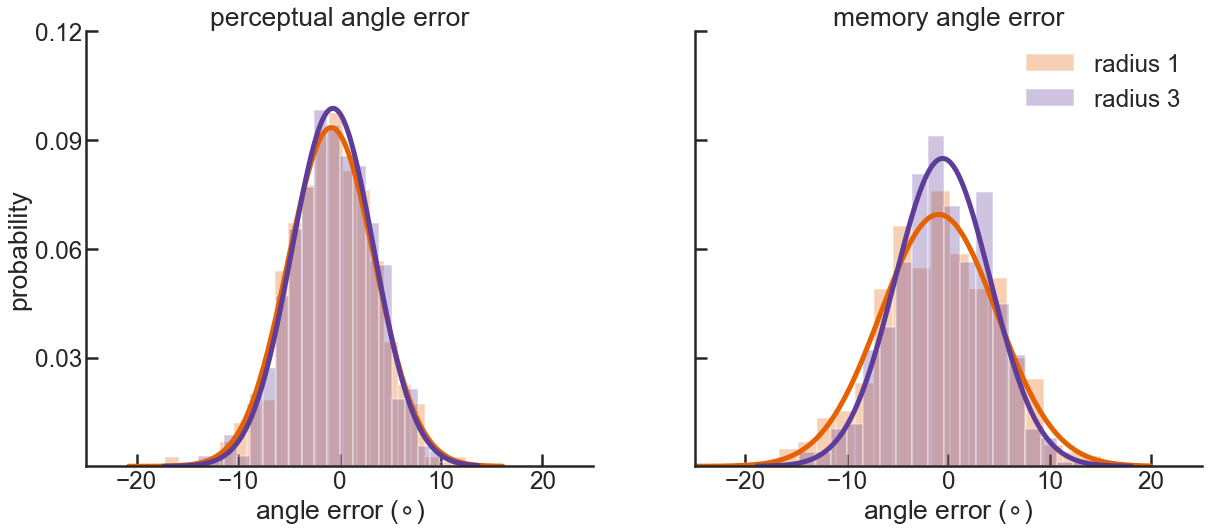

In [11]:
### Figure paper

f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

plt.subplot(121)

# read data from a text file. One number per line
datos_d0_r1 = df_cont.loc[ (df_cont['r_T']==7.72) & (df_cont['delay']==0)   , 'A_err']
mu_r1, sigma_r1 = norm.fit(datos_d0_r1)
datos_d0_r3 = df_cont.loc[ (df_cont['r_T']==13.68) & (df_cont['delay']==0)   , 'A_err']
mu_r3, sigma_r3 = norm.fit(datos_d0_r3)

sns.distplot(datos_d0_r1, color= c_r1, fit=norm, kde=False, fit_kws={"color":c_r1, 'linewidth':5}, ax=ax, hist_kws={'alpha':0.3})
sns.distplot(datos_d0_r3, color=c_r3, fit=norm, kde=False, fit_kws={"color":c_r3, 'linewidth':5}, ax=ax, hist_kws={'alpha':0.3})

#plot
plt.xlabel(r'angle error ($\circ$)')
plt.ylabel('probability')
#plt.title(r'$\mathrm{Delay=0:}\ \sigma_{r1}=%.3f,\ \sigma_{r3}=%.3f$' %(sigma_r1, sigma_r3))
plt.title('perceptual angle error')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.yticks([0.03,0.06,0.09, 0.12])
plt.legend(frameon=False)
plt.ylim(0,0.120)
plt.xlim(-25,25)


plt.subplot(122)

# read data from a text file. One number per line
datos_d3_r1 = df_cont.loc[ (df_cont['r_T']==7.72) & (df_cont['delay']==3)   , 'A_err']
mu_r1, sigma_r1 = norm.fit(datos_d3_r1)
datos_d3_r3 = df_cont.loc[ (df_cont['r_T']==13.68) & (df_cont['delay']==3)   , 'A_err']
mu_r3, sigma_r3 = norm.fit(datos_d3_r3)

sns.distplot(datos_d3_r1, color= c_r1, fit=norm, kde=False, label='radius 1', fit_kws={"color":c_r1, 'linewidth':5}, ax=ax2, hist_kws={'alpha':0.3})
sns.distplot(datos_d3_r3, color=c_r3, fit=norm, kde=False, label='radius 3', fit_kws={"color":c_r3, 'linewidth':5},  ax=ax2, hist_kws={'alpha':0.3})

#plot
plt.xlabel(r'angle error ($\circ$)')
plt.ylabel('')
#plt.title(r'$\mathrm{Delay=3:}\ \sigma_{r1}=%.3f,\ \sigma_{r3}=%.3f$' %(sigma_r1, sigma_r3))
plt.title('memory angle error')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.yticks([0.03,0.06,0.09, 0.12], ['', ''])
plt.legend(frameon=False)
plt.ylim(0,0.120)
plt.xlim(-25,25)
plt.legend(frameon=False)

plt.show()

# Modeling

In [12]:
df = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model\\please.xlsx')
df=df.loc[df['success']==True]
df_b1 = df[['b1', 'decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']]
df_b1.columns=['bias', 'decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']
df_b2 =df[['b2','decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']]
df_b2.columns=['bias', 'decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']

In [13]:
df_c = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model\\please_close.xlsx')
df_c=df_c.loc[df_c['success']==True]
df_b3 = df_c[['b1', 'decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']]
df_b3.columns=['bias', 'decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']
df_b4 =df_c[['b2','decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']]
df_b4.columns=['bias', 'decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']

In [14]:
df=pd.concat([df_b1, df_b2, df_b3, df_b4])

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


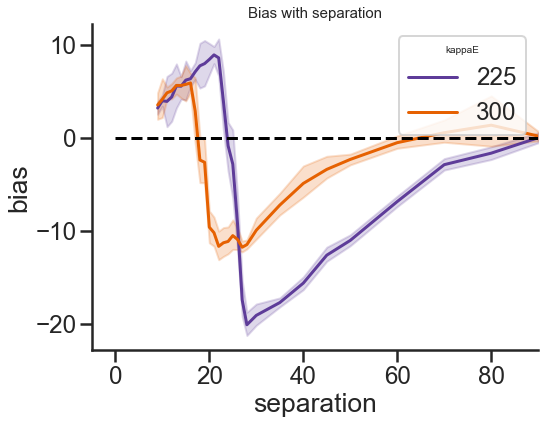

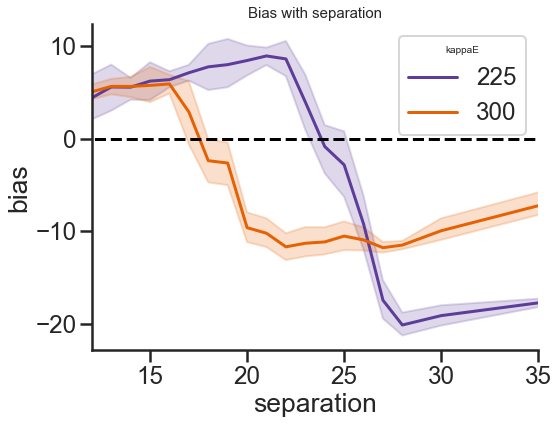

In [15]:
plt.figure(figsize=(8,6))
g = sns.lineplot( x="separation", y="bias", hue='kappas_E', ci=95 , palette=[c_r3, c_r1], data=df, legend=False) 
plt.plot([0, max(df['separation'])], [0,0], 'k--') 
plt.title('Bias with separation', fontsize=15) #condition title
plt.gca().spines['right'].set_visible(False) #no right axis
plt.gca().spines['top'].set_visible(False) #no  top axis
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.legend(title='kappaE', loc='upper right', labels=[str(i) for i in [225, 300]] )
plt.xlim(-5, 90)
#plt.xlim(20, 30)
plt.show(block=False)

#####

plt.figure(figsize=(8,6))
g = sns.lineplot( x="separation", y="bias", hue='kappas_E', ci=95 , palette=[c_r3, c_r1], data=df, legend=False) 
plt.plot([0, max(df['separation'])], [0,0], 'k--') 
plt.title('Bias with separation', fontsize=15) #condition title
plt.gca().spines['right'].set_visible(False) #no right axis
plt.gca().spines['top'].set_visible(False) #no  top axis
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.legend(title='kappaE', loc='upper right', labels=[str(i) for i in [225, 300]] )
plt.xlim(-5, 90)
plt.xlim(12, 35)
plt.show(block=False)

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"


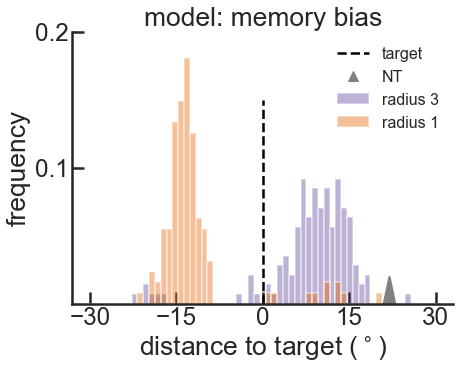

In [16]:
values_225 = df.loc[(df['separation']==22) & (df['kappas_E']==225) , 'bias']
values_300 =  df.loc[(df['separation']==22) & (df['kappas_E']==300) , 'bias']
#values_225 = values_225*12/22
#values_300 = values_300*12/22


f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

plt.plot([0, 0], [0,0.15], 'k--', linewidth=2.5, label='target');
plt.plot((700), "^", color='grey', markersize=10, label='NT');

sns.distplot(values_225, color=c_r3, bins=np.linspace(-50,50,100), kde=False, fit=norm, 
              label='radius 3', fit_kws={"color":c_r3, 'linewidth':0}, ax=ax2)
sns.distplot(values_300,  color=c_r1, bins=np.linspace(-50,50,100), kde=False, fit=norm, 
             label='radius 1', fit_kws={"color":c_r1, 'linewidth':0}, ax=ax2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xlabel(r'distance to target ($^\circ$)')
plt.ylabel('frequency')
#plt.text(8, 60, 'attraction', fontsize=22);
#plt.text(-10, 60, 'repulsion', fontsize=22);
#plt.title(r'12$\circ$: Delay3 - Delay0')
plt.yticks([0.1,0.2, 0.3])
plt.xticks([-30, -15, 0, 15, 30])
plt.xlim(-33, 33)
plt.ylim(0,0.2)
l = plt.legend(loc='best', frameon=False, prop={'size': 16})


pts = [(21, 0.), (22, 0.02), (23, 0.)]
triangle = plt.Polygon(pts, color='grey', fill=True, edgecolor='grey')
ax2.add_patch(triangle)

plt.title('model: memory bias')

f.delaxes(ax)


plt.show()

In [53]:
df_1_a1 = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model\\please_11.xlsx')
df_1_a2 = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model\\please_12.xlsx')

df_1=pd.concat([df_1_a1, df_1_a2])
df_1 = df_1.loc[df_1['success']==True]
df_1 = df_1[abs(df_1.b2)<1.5*np.std(df_1.b2)]

df_1['abs_bias']=abs(df_1['b2'])

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


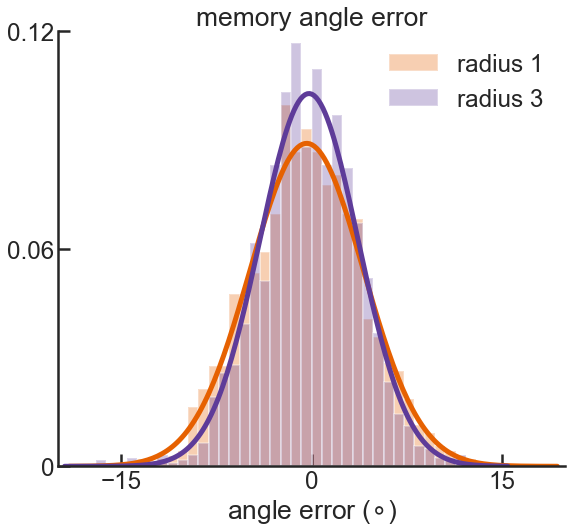

In [54]:

f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

plt.subplot(121)

sns.distplot(df_1.loc[df_1['kappas_E']==300, 'b2'], color=c_r1,  bins=np.linspace(-30,30,75),
             label='radius 1', kde=False, fit=norm,  fit_kws={"color":c_r1, 'linewidth':5},
            hist_kws={'alpha':0.3}, ax=ax)

sns.distplot(df_1.loc[df_1['kappas_E']==225, 'b2'], color=c_r3,  bins=np.linspace(-30,30,75),
             label='radius 3', kde=False, fit=norm,  fit_kws={"color":c_r3, 'linewidth':5},
            hist_kws={'alpha':0.3}, ax=ax)



plt.xlabel(r'angle error ($\circ$)')
plt.ylabel('')
#plt.title(r'$\mathrm{Delay=3:}\ \sigma_{r1}=%.3f,\ \sigma_{r3}=%.3f$' %(sigma_r1, sigma_r3))
plt.title('memory angle error')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
#plt.yticks([0, 0.06,  0.012], ['', ''])
plt.yticks([0, 0.06,  0.12], [0, 0.06, 0.12])
plt.xticks([-15, 0, 15])
plt.legend(frameon=False, loc='best')
plt.ylim(0,0.12)
plt.xlim(-20, 20);
plt.legend(frameon=False)

f.delaxes(ax2)

In [55]:
res_m = smf.ols(formula='abs_bias ~ kappas_E', data=df_1).fit()
print(res_m.summary())

                            OLS Regression Results                            
Dep. Variable:               abs_bias   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     32.66
Date:                Mon, 09 Dec 2019   Prob (F-statistic):           1.20e-08
Time:                        11:15:25   Log-Likelihood:                -7748.3
No. Observations:                3275   AIC:                         1.550e+04
Df Residuals:                    3273   BIC:                         1.551e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5070      0.322      4.683      0.0

In [56]:
df_fg = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model\\please_fit_gauss.xlsx')
df_fg=df_fg.loc[df_fg['success']==True]
df_fg = df_fg[abs(df_fg.gaussian_std)<1.5*np.std(df_fg.gaussian_std)]
df_fg = df_fg[df_fg.gaussian_std>0]

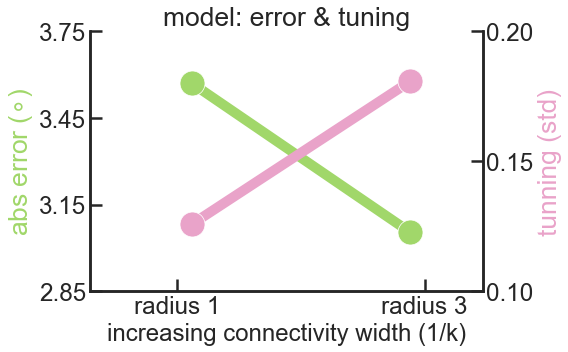

In [57]:
plt.figure(figsize=(8,5))

c_tuning= '#e9a3c9'
c_error = '#a1d76a'

ax = sns.lineplot( x="kappas_E", y="abs_bias", ci=None, data=df_1, markers=True,  
                 linewidth=10, marker="o", markersize=25, color=c_error) 
plt.ylim(2.85, 3.75)
plt.yticks([2.85, 3.15, 3.45, 3.75])
plt.ylabel(r'abs error ($\circ$)')
plt.gca().spines['top'].set_visible(False)
plt.tick_params(direction='in')
plt.xlabel('')
plt.xlim(200, 335)
plt.gca().invert_xaxis()
plt.xlabel('increasing connectivity width (1/k)', fontsize=24)
ax.yaxis.label.set_color(c_error)

ax2 = ax.twinx()
ax = sns.lineplot( x="kappas_E", y="gaussian_std", ci=None, data=df_fg, markers=True,  
                 linewidth=10, marker="o", markersize=25, color=c_tuning, ax=ax2) 

plt.ylim(0.1, 0.2)
plt.gca().spines['top'].set_visible(False)
plt.yticks([0.1, 0.15, 0.2])
plt.ylabel('tunning (std)')
plt.tick_params(direction='in')
plt.xlabel('increasing connectivity width (1/k)', fontsize=24)
plt.xticks([305, 220], ['radius 1','radius 3'], rotation=45)
ax.yaxis.label.set_color(c_tuning)


plt.title('model: error & tuning')
plt.tight_layout()
plt.show()

## Monkeys

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with lab

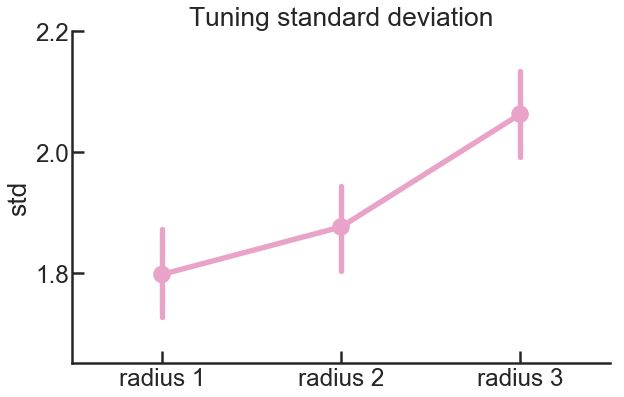

In [62]:
df_m = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\figures\\df_stds_monkeys.xlsx')

c_tuning= '#e9a3c9'
sns.factorplot( x="radius", y="tuning_std", data=df_m, color=c_tuning, ci=68, size=6, aspect=1.5);

plt.xlabel('')
plt.ylabel('std')
plt.title('Tuning standard deviation')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xticks([0,1,2], ['radius 1', 'radius 2', 'radius 3'])
plt.legend(frameon=False)
plt.ylim(1.65, 2.2);
plt.yticks([ 1.8, 2, 2.2]);


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


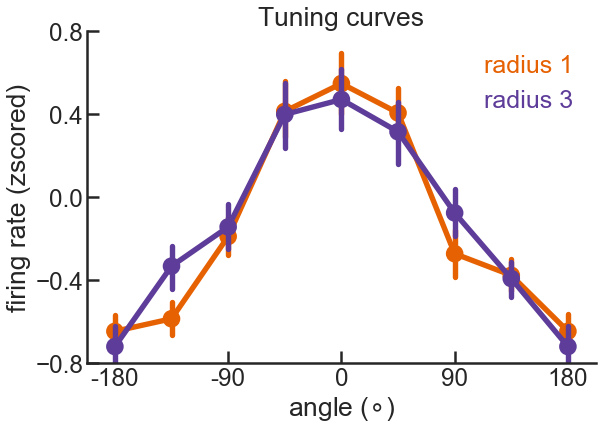

In [59]:
df_firings = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\figures\\df_norm_firings.xlsx')

c_tuning= '#e9a3c9'

c_r1= '#e66101' #'#fdb863' # '#998ec3' #'#d8b365' #, '#8da0cb'
c_r3= '#5e3c99' #'#b2abd2' #'#f1a340' #'#5ab4ac' #'#fc8d62

sns.factorplot( x="angle", y="firing", data=df_firings, hue='radius', 
               palette=[c_r1, c_r3], ci=68, size=6, aspect=1.5, legend=False);

plt.xlabel(r'angle ($\circ$)');
plt.ylabel('firing rate (zscored)')
plt.title('Tuning curves')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xticks([ 0, 2, 4, 6, 8], [-180, -90, 0, 90, 180]);

l = plt.legend(loc=1, frameon=False, prop={'size': 25});
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);

plt.ylim(-0.8, 0.8);
plt.yticks([ -0.8, -0.4, 0, 0.4, 0.8]);
